In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import re
import os

In [2]:
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [3]:
# --- Set Nature-style plotting params ---
sns.reset_orig()
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'arial'
rcParams['font.size'] = 10
rcParams['axes.labelsize'] = 10
rcParams['legend.fontsize'] = 9
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams['axes.titlesize'] = 12

In [4]:
# Import tables 
main_table = pd.read_csv(r'data/Tables/CSV/main_table.csv')
production_table = pd.read_csv(r'data/Tables/CSV/production_table.csv')
env_table = pd.read_csv(r'data/Tables/CSV/env_table.csv')
protected_land_table = pd.read_csv(r'data/Tables/CSV/protected_land_table.csv')
land_cover_table = pd.read_csv(r'data/Tables/CSV/land_cover_table.csv')
env_int_table = pd.read_csv(r'data/Tables/CSV/env_int_table.csv')
reserves_table = pd.read_csv(r'data/Tables/CSV/reserves_table.csv')
energy_table = pd.read_csv(r'data/Tables/CSV/energy_table.csv')
tailings_table = pd.read_csv(r'data/Tables/CSV/tailings_table.csv')
polygon_table = pd.read_csv(r'data/Tables/CSV/land_occupation_table.csv')
archetypes_table = pd.read_csv(r'data/Tables/CSV/archetypes_table.csv')
water_risk_table = pd.read_csv(r'data/Tables/CSV/water_risk_table.csv')
climate_category_table = pd.read_csv(r'data/Tables/CSV/climate_category_table.csv')
weather_table = pd.read_csv(r'data/Tables/CSV/weather_table.csv')
conflict_table = pd.read_csv(r'data/Tables/CSV/conflict_table.csv')
population_table = pd.read_csv(r'data/Tables/CSV/population_table.csv')
peatland_table = pd.read_csv(r'data/Tables/CSV/peatland_table.csv')

# Heatmap of data coverage per table

In [5]:
csv_dir = "data/Tables/CSV"

# Load main facility table
main_df = pd.read_csv(os.path.join(csv_dir, "main_table.csv"))
main_df = main_df[["main_id", "facility_type"]]
main_df["main_id"] = main_df["main_id"].astype(str).str.strip().str.upper()

# List all other *_table.csv files except the main_table
csv_files = [f for f in os.listdir(csv_dir)
             if f.endswith("_table.csv") and f != "main_table.csv"]

# Start with main table
coverage_df = main_df.copy()

# Count rows per main_id in each table
for file in csv_files:
    table_name = file.replace("_table.csv", "")
    df = pd.read_csv(os.path.join(csv_dir, file))

    if "main_id" in df.columns:
        df["main_id"] = df["main_id"].astype(str).str.strip().str.upper()
        row_counts = df["main_id"].value_counts().rename(table_name)
        coverage_df = coverage_df.merge(row_counts, how="left", left_on="main_id", right_index=True)
    else:
        coverage_df[table_name] = 0

# Replace NaNs with 0 and ensure integer type
for col in coverage_df.columns[2:]:
    coverage_df[col] = coverage_df[col].fillna(0).astype(int)

coverage_df

,main_id,facility_type,archetypes,climate_category,conflict,energy,env_int,env,land_cover,land_occupation,peatland,population,prioritization_area,production,protected_land,reserves,tailings,water_risk,weather
0,QC-MAIN-5801B453,project,0,9,0,0,0,0,1,2,1,4,1,0,30,0,0,32,128
1,QC-MAIN-D29E0839,mining,1,9,0,0,0,0,1,6,1,4,1,0,44,2,0,32,128
2,QC-MAIN-F1FF4920,project,0,9,0,0,0,0,1,10,1,4,1,0,46,0,0,32,128
3,NU-MAIN-4EA8AC9D,mining,1,9,0,8,2,19,1,0,1,4,1,5,1,4,0,32,128
4,QC-MAIN-E7E6A960,mining,1,9,0,8,2,247,1,6,1,4,1,1,41,5,2,32,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,ON-MAIN-C5FEFB01,mining,1,9,0,8,6,19,1,4,1,4,1,5,11,5,0,32,128
266,BC-MAIN-FEB13C30,project,0,9,0,0,0,0,1,0,1,4,1,0,24,0,0,32,128
267,YT-MAIN-5E0D8B48,project,0,9,0,0,0,0,1,0,1,4,1,0,2,0,0,32,128
268,ON-MAIN-12C68D49,project,0,9,0,0,0,0,1,0,1,4,1,0,1,0,0,32,128


In [6]:
coverage_df.to_csv(r'results/data_coverage/data_coverage_per_table.csv', index=False)

In [25]:
def plot_heatmap(
    df_all,
    filename=None,
    bins=[-0.1, 0.5, 1.5, 5, 10, 20, 50, 100, 200, 1000],
    display_labels=["0", "1", "2–4", "5–9", "10–19", "20–49", "50–99", "100–199", "200+"],
    cmap_name="tab20"
):
    """
    Create a combined heatmap with vertically stacked subplots for each facility type.
    Row height is proportional to number of facilities to show coverage intensity.

    Parameters:
        df_all (pd.DataFrame): Must contain 'main_id', 'facility_type', and per-table counts.
        filename (str): Path to save the figure as PDF. If None, figure is only shown.
        bins (list): Bin edges to categorize count values.
        display_labels (list): Human-readable labels for bins.
        cmap_name (str): Color palette name for Seaborn (e.g., 'YlOrRd', 'tab20').
    """

    df_all = df_all.copy()
    df_all = df_all.set_index("main_id")
    facility_types = ["mining", "manufacturing", "project"]

    data_cols = df_all.columns.drop("facility_type")
    for col in data_cols:
        df_all[col] = df_all[col].astype(int)

    bin_labels = list(range(len(bins) - 1))

    # Prepare binned data per facility type
    data_dict = {}
    for ftype in facility_types:
        df = df_all[df_all["facility_type"].str.lower() == ftype]
        data = df[data_cols].copy()
        data["total"] = data.sum(axis=1)
        data = data.sort_values("total", ascending=False).drop(columns="total")
        data_binned = data.apply(
            lambda col: pd.cut(col, bins=bins, labels=bin_labels, include_lowest=True)
        ).astype(float)
        data_dict[ftype] = data_binned

    # Calculate dynamic row heights
    row_heights = [len(data_dict[ftype]) for ftype in facility_types]
    total_rows = sum(row_heights)
    height_ratios = [h / total_rows for h in row_heights]

    # Setup figure with fixed width, flexible height
    fig_height = 6
    fig, axes = plt.subplots(
        nrows=3,
        figsize=(7.2, fig_height),
        gridspec_kw={"height_ratios": height_ratios},
        sharex=True
    )
    plt.subplots_adjust(hspace=0.4, right=0.85)

    # Use a qualitative colormap
    try:
        cmap = sns.color_palette(cmap_name, len(bin_labels))
    except:
        cmap = sns.color_palette("YlOrRd", len(bin_labels))

    # Plot each facility type
    for ax, ftype in zip(axes, facility_types):
        sns.heatmap(
            data_dict[ftype],
            cmap=cmap,
            ax=ax,
            cbar=False,
            linewidths=0.1,
            linecolor="lightgray",
            xticklabels=True,
            yticklabels=False
        )
        ax.set_title(f"{ftype.capitalize()} facilities")
        ax.set_ylabel("")

    # Shared colorbar on right
    cbar_ax = fig.add_axes([0.88, 0.3, 0.02, 0.4])
    norm = mcolors.BoundaryNorm(bins, len(bin_labels))
    sm = plt.cm.ScalarMappable(cmap=mcolors.ListedColormap(cmap), norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, ticks=[(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)])
    cbar.ax.set_yticklabels(display_labels)
    cbar.ax.set_title("", fontsize=9)

    axes[-1].set_xlabel("")

    if filename:
        plt.savefig(filename, dpi=600, bbox_inches="tight", format="pdf")
        print(f"✅ Saved: {filename}")
    plt.show()

✅ Saved: results/data_coverage/data_coverage_heatmap.pdf


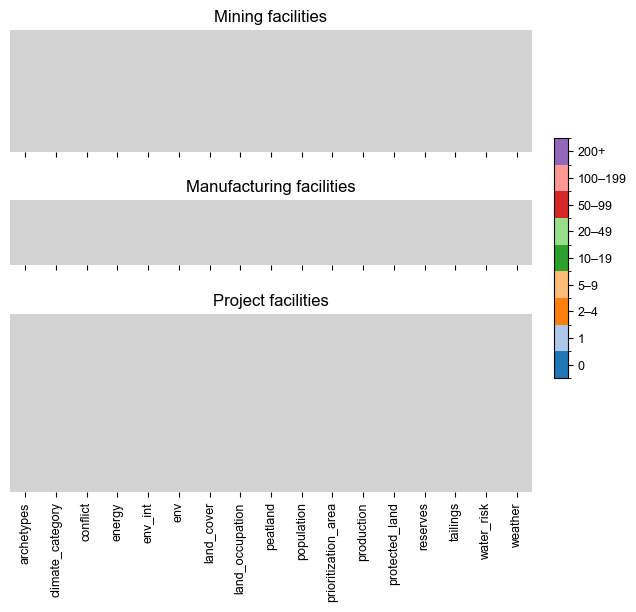

In [26]:
# Run example with final settings
plot_heatmap(
    coverage_df,
    filename="results/data_coverage/data_coverage_heatmap.pdf",
    cmap_name="tab20"
)

# Number of commodities covered

In [84]:
raw_com_counts = main_table[["facility_type", "commodities"]].dropna()
raw_com_counts = raw_com_counts.value_counts().reset_index(name="count")
raw_com_counts

,facility_type,commodities,count
0,mining,Gold,26
1,manufacturing,Steel,14
2,mining,"Gold, silver",11
3,mining,Iron,8
4,project,Lithium (spodumene),7
...,...,...,...
135,mining,"Nickel, copper, cobalt",1
136,mining,"Nickel, cobalt, copper, platinum group metals,...",1
137,mining,Lithium,1
138,mining,Ilmenite,1


In [85]:
# Function to clean and split commodity string from the raw grouped data
def split_commodities(row):
    facility_type = row["facility_type"]
    entry = row["commodities"]
    count = row["count"]
    
    # Remove anything in parentheses
    entry = re.sub(r"\(.*?\)", "", entry)
    # Split on common delimiters (comma, slash, semicolon, " and ", etc.)
    split_items = re.split(r",|;|/|&| and ", entry)
    # Clean and filter items
    cleaned_items = [item.strip().lower() for item in split_items if item.strip()]
    
    return [(facility_type.lower(), item, count) for item in cleaned_items]

In [86]:
# Apply splitting and flatten the result
split_records = []
for _, row in raw_com_counts.iterrows():
    split_records.extend(split_commodities(row))
    
# Create DataFrame and group by to aggregate counts
commodities_df = pd.DataFrame(split_records, columns=["facility_type", "commodity", "count"])
commodities_df = commodities_df.groupby(["facility_type", "commodity"], as_index=False)["count"].sum()
commodities_df

,facility_type,commodity,count
0,manufacturing,alumina,2
1,manufacturing,aluminum,9
2,manufacturing,aluminum chemicals,1
3,manufacturing,ammonium sulfate,1
4,manufacturing,bismuth,1
...,...,...,...
99,project,uranium,7
100,project,vanadium,5
101,project,zinc,27
102,project,zircon,1


In [88]:
# Define keyword-based mapping rules
keyword_mapping = {
    "aluminum": ["aluminum", "aluminum chemicals"],
    "copper": ["copper", "copper anodes", "copper cathodes", "copper oxide", "copper sulfate", "copper sulfide"],
    "cobalt": ["cobalt", "electrolytic cobalt"],
    "iron": ["iron", "iron ore"],
    "lead": ["lead", "recycled lead"],
    "lithium": ["lithium", "lithium metal", "lithium hydroxide"],
    "magnesium": ["magnesium", "magnesium oxide"],
    "manganese": ["manganese", "manganese sulphate"],
    "nickel": ["nickel", "nickel matte", "nickel-copper matte containing cobalt"],
    "pgms": ["platinum group metals"],
    "rees": ["rare earth elements"],
    "selenium": ["selenium", "selenium cake"],
    "tellurium": ["tellurium", "tellurium dioxide cake"],
    "titanium": ["titanium", "titanium dioxide"],
    "zirconium": ["zirconium", "zircon"],
    # Add more groupings as needed
}

In [89]:
# Invert the mapping for easier lookup
reverse_mapping = {}
for group, keywords in keyword_mapping.items():
    for keyword in keywords:
        reverse_mapping[keyword] = group

# Assign mapping based on exact or keyword match
def map_commodity(commodity):
    for keyword, group in reverse_mapping.items():
        if commodity.lower().startswith(keyword):
            return group
    return commodity  # default to original if no mapping found

In [90]:
commodities_df["commodity_mapping"] = commodities_df["commodity"].str.lower().apply(map_commodity)

In [91]:
commodities_df

,facility_type,commodity,count,commodity_mapping
0,manufacturing,alumina,2,alumina
1,manufacturing,aluminum,9,aluminum
2,manufacturing,aluminum chemicals,1,aluminum
3,manufacturing,ammonium sulfate,1,ammonium sulfate
4,manufacturing,bismuth,1,bismuth
...,...,...,...,...
99,project,uranium,7,uranium
100,project,vanadium,5,vanadium
101,project,zinc,27,zinc
102,project,zircon,1,zirconium


In [93]:
 # Drop when commodity is battery materials, composites
commodities_covered = commodities_df[~commodities_df["commodity"].isin(["battery materials", "composites"])]

In [94]:
# Aggregate to recreate coverage_summary
coverage_summary = commodities_covered.groupby(["facility_type", "commodity_mapping"])["count"].sum().reset_index()

# Sort for plotting
sorted_commodities = coverage_summary.groupby("commodity_mapping")["count"].sum().sort_values(ascending=False).index
coverage_summary["commodity_mapping"] = pd.Categorical(
    coverage_summary["commodity_mapping"], categories=sorted_commodities, ordered=True
)

# Define color palette
facility_palette = {
    "mining": "#393e41",
    "project": "#c8d5b9",
    "manufacturing": "#e94f37"
}

# Set matplotlib params
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'arial'
rcParams['font.size'] = 10
rcParams['axes.labelsize'] = 10
rcParams['legend.fontsize'] = 9
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams['axes.titlesize'] = 12
sns.reset_orig()

# Plot
fig, ax = plt.subplots(figsize=(10, 4))

sns.barplot(
    data=coverage_summary,
    x="commodity_mapping",
    y="count",
    hue="facility_type",
    palette=facility_palette,
    ax=ax
)

ax.set_xlabel("")
ax.set_ylabel("Number of facilities")

# Add separators
for tick in range(len(sorted_commodities)):
    ax.axvline(x=tick - 0.5, color="lightgray", linestyle=":", linewidth=0.5)

ax.tick_params(axis='x', rotation=90)
ax.legend(title='', loc="upper right", frameon=False)
fig.tight_layout()

# Save
final_export_path = "results/data_coverage/commodities_covered.pdf"
fig.savefig(final_export_path, dpi=600, bbox_inches='tight', format='pdf')